### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datetime import datetime
import torchvision.models as models
from torchvision import datasets, transforms
from data_loader_classification import get_train_valid_loader, get_test_loader
from kornia.losses import SSIMLoss

### Import Plotting

In [2]:
try:
    from plotting_acc import plot_autoencoder_stats, save_img, display_multiple_img
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

### Initiate Variables for data loaders

In [3]:
batch_size = 16
num_workers = 2

### Load data


In [4]:
drive_path = 'data/train/classification'
test_path = 'data/test'
model_path = 'models/'
label_path = 'data/train/classification_groundtruth/labels.csv'

<Figure size 432x288 with 0 Axes>

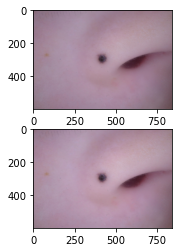

In [5]:
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((600,840)),    
            transforms.ToTensor()
            ])

noisy_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((450,700)),
            transforms.Resize((600,840)),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.4)],p=0.6),     # randomly add brightness noise
            transforms.ToTensor()
            ])

train_loader,valid_loader, n_classes = get_train_valid_loader(data_dir=drive_path,
                                                  label_path=label_path,
                                                  batch_size=batch_size,
                                                  random_seed=1996,   #remove this for random, otherwise always the same
                                                  noisy_transform = noisy_transform,
                                                  transform = transform,
                                                  num_workers=num_workers,
                                                  valid_size=0.30,
                                                  shuffle=True,
                                                  show_sample=True)

### Plot some Images

tensor([0, 1, 1, 1, 4, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1])


<Figure size 432x288 with 0 Axes>

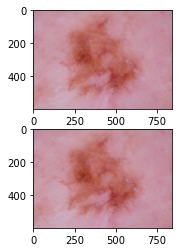

In [6]:
# Load a batch of images into memory
images, noisy_images, labels = next(iter(train_loader))

plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
print(labels)
axarr[0].imshow(np.transpose(images[0], (1, 2, 0)))
axarr[1].imshow(np.transpose(noisy_images[0], (1, 2, 0)))

### Neural Network

In [7]:
# compute the dimensions of the convolution
def compute_conv_dim(dim_size,kernel_size_conv,padding_conv=0,stride_conv=1):
    return int((dim_size - kernel_size_conv + 2 * padding_conv) / stride_conv + 1)

In [8]:
print("height_conv_1:", compute_conv_dim(600,4,1,2))
print("width_conv_1:", compute_conv_dim(840,4,1,2))
print("height_conv_2", compute_conv_dim(300,4,1,2))
print("width_conv_2", compute_conv_dim(420,4,1,2))
print("height_conv_3", compute_conv_dim(150,4,1,2))
print("width_conv_3", compute_conv_dim(210,4,1,2))
print("height_conv_4", compute_conv_dim(75,4,1,2))
print("width_conv_4", compute_conv_dim(105,4,1,2))

height_conv_1: 300
width_conv_1: 420
height_conv_2 150
width_conv_2 210
height_conv_3 75
width_conv_3 105
height_conv_4 37
width_conv_4 52


In [9]:
# Set values for some hyperparameters
# dropout probability
p = 0.5
# negative slope for LeakyRelu
negative_slope = 0.2

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)

        # Decoder
        self.deconv4 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(128*2, 64, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64*2, 32, 4, stride=2, padding=1)     # we need the channels to be doubled in input from the previous output because of skip connections
        self.deconv1 = nn.ConvTranspose2d(32*2, 3, 4, stride=2, padding=1)

        self.dropout = nn.Dropout(p=p)
        self.act_fn = nn.LeakyReLU(negative_slope=negative_slope)
        # self.act_fn = nn.LeakyReLU()
        self.out_fn = nn.Sigmoid()
        
        # Classifier
        self.classifier = nn.Sequential(
        nn.Flatten(),
        # standardize by adding BN as first layer for the classifier
        nn.BatchNorm1d(37*52*256),
        nn.Linear(37*52*256, 256),
        nn.BatchNorm1d(256),
        self.act_fn,
        self.dropout,
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        self.act_fn,
        self.dropout,
        nn.Linear(128, n_classes),
        )

    def forward(self, x):        # x: 3x600x840
        # Encoder
        z1 = self.conv1(x)       
        z1 = self.act_fn(z1)
        z1 = self.dropout(z1)  

        z2 = self.conv2(z1)        
        z2 = self.act_fn(z2)
        z2 = self.dropout(z2)

        z3 = self.conv3(z2)       
        z3 = self.act_fn(z3)
        z3 = self.dropout(z3)

        z4 = self.conv4(z3)        
        z = self.act_fn(z4)
        
        # Classification
        y_hat = self.classifier(z)
        
        # Decoder
        x_hat = self.deconv4(z)
        x_hat = self.act_fn(x_hat)

        x_hat = torch.cat((x_hat,z3),1)  
        x_hat = self.deconv3(x_hat)
        x_hat = self.act_fn(x_hat)

        x_hat = torch.cat((x_hat,z2),1)     # take also z2 and feed it to the middle deconv layer
        x_hat = self.deconv2(x_hat)
        x_hat = self.act_fn(x_hat)

        x_hat = torch.cat((x_hat,z1),1)     # take also z1 and feed it to the last deconv layer
        x_hat = self.deconv1(x_hat)
        x_hat = self.out_fn(x_hat)

        return {'z': z, 'x_hat': x_hat, 'y_hat': y_hat}



### Save and Print Model

In [11]:
net = Autoencoder()
print(net)

Autoencoder(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (act_fn): LeakyReLU(negative_slope=0.2)
  (out_fn): Sigmoid()
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): BatchNorm1d(492544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=4

# Check Shapes

In [12]:
x, x_noisy, y = next(iter(train_loader))
outputs = net(x)

print(f"x.shape = {x.shape}")
print(f"x_hat.shape = {outputs['x_hat'].shape}")
print(f"y_hat.shape = {outputs['y_hat'].shape}")

x.shape = torch.Size([16, 3, 600, 840])
x_hat.shape = torch.Size([16, 3, 600, 840])
y_hat.shape = torch.Size([16, 7])


### Loss Criterion and Optimizer

In [13]:
# Set parameters
num_epochs = 100
lr = 0.0004
# determines whether the reconstruction or classification loss is more important
# high alpha means reconstruction is more important and vice versa
alpha = 0.97
# adjusting the weight of combined ae loss functions
ae_alpha = 0.7
# L2 regularization
weight_decay=1e-4

lr, num_epochs, alpha, ae_alpha

(0.0004, 100, 0.97, 0.7)

In [14]:
def combine_loss(loss1, loss2, alpha):
    loss = alpha * loss1 + (1 - alpha) * loss2
    return loss

#Loss function
ssim_loss_function = SSIMLoss(5)
l1_loss_function = nn.L1Loss()
clf_loss_function = nn.CrossEntropyLoss()

#Optimizer
net = Autoencoder()
optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)

### CUDA

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
net = net.to(device)
print(net)   

>> Using device: cuda:0
Autoencoder(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (act_fn): LeakyReLU(negative_slope=0.2)
  (out_fn): Sigmoid()
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): BatchNorm1d(492544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

## Save model

In [16]:
# Save the model with the specified parameters
def save_model(model):
  ae_loss_name = "SSIM+L1"
  clf_loss_name = "CE"
  now = str(datetime.now()).replace(':', '-').replace(' ', '_')

  model_filename = f'{now}_model_{ae_loss_name}_{clf_loss_name}_EPOCHS={num_epochs}_LR={lr}_ALPHA={alpha}_' + 'ACC={:.0f}%_LOSS={:.4f}'.format(valid_acc[-1], valid_loss[-1])
  print(model_filename)

  torch.save(model, model_filename)

### Training and Testing

## GPU

loss_clf tensor(0.0008, device='cuda:0', grad_fn=<MulBackward0>)
SSIM tensor(0.0263, device='cuda:0', grad_fn=<MeanBackward0>)
L1 tensor(0.0464, device='cuda:0', grad_fn=<L1LossBackward0>)
loss_ae tensor(0.0314, device='cuda:0', grad_fn=<MulBackward0>)
loss tensor(0.0322, device='cuda:0', grad_fn=<AddBackward0>)
Validation set: Accuracy: 163/253 (64%)



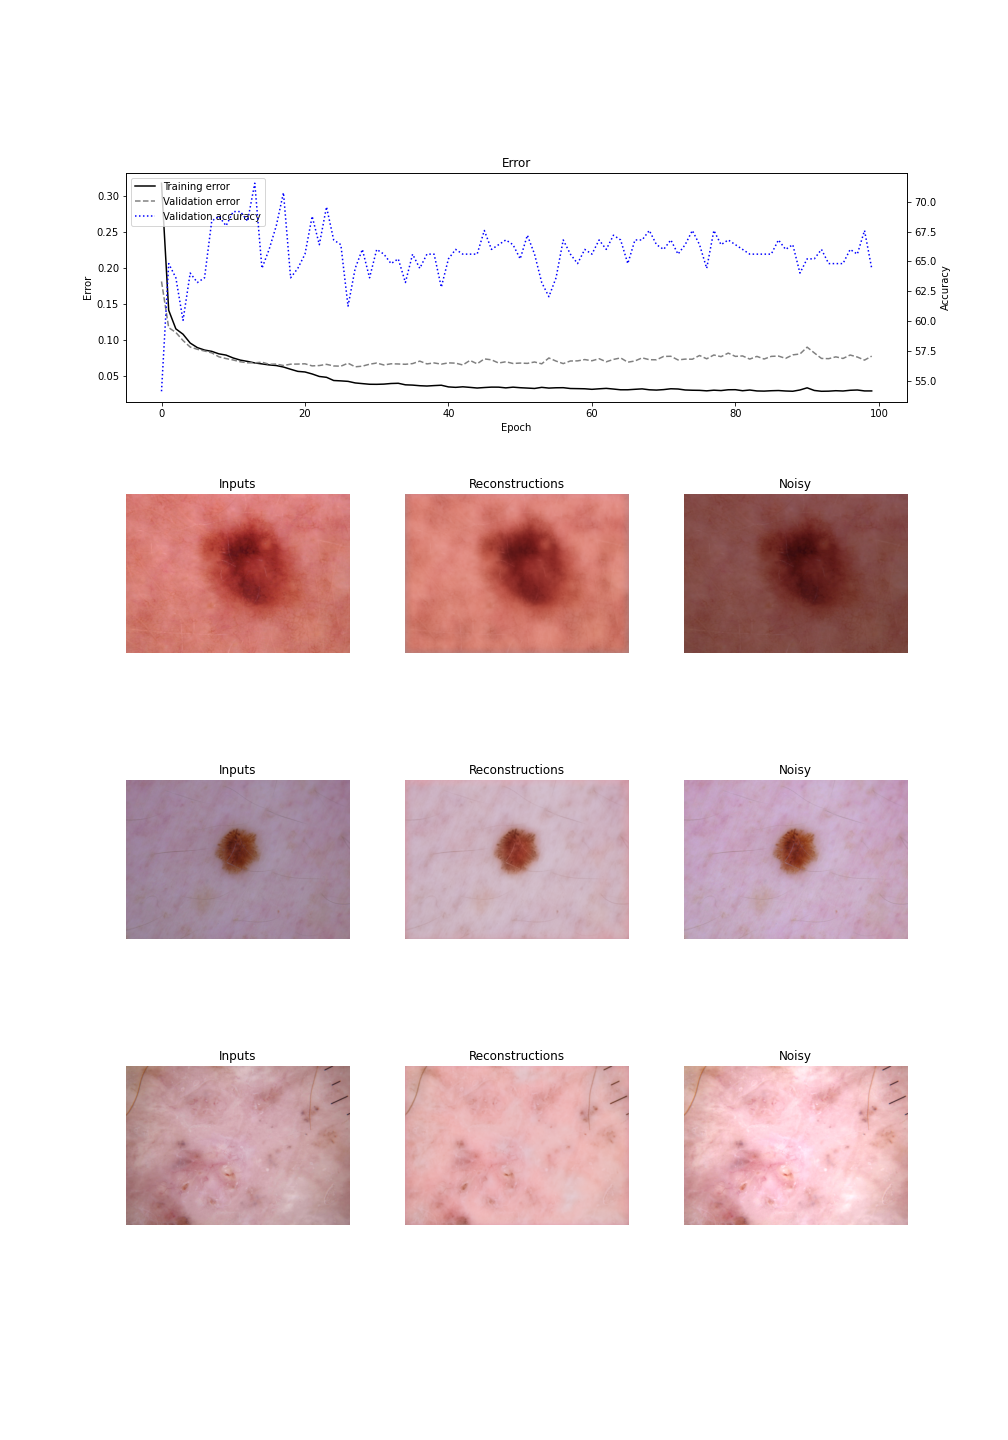

In [17]:
train_loss = []
valid_loss = []
valid_acc = []

for epoch in range(num_epochs):
    batch_loss = []
    batch_val_loss = []
    net.train()
    count = 0
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, noisy_x, y in train_loader:
        count += 1  
        x, noisy_x, y = x.cuda(), noisy_x.cuda(), y.cuda()
        outputs = net(noisy_x)
        x_hat = outputs['x_hat'].cuda()
        y_hat = outputs['y_hat'].cuda()

        # Calculate the loss for this batch
        loss_ae1 = ssim_loss_function(x_hat, x)
        loss_ae2 = l1_loss_function(x_hat, x)
        loss_ae = combine_loss(loss_ae1, loss_ae2, ae_alpha) 
        loss_clf = clf_loss_function(y_hat, y)
        loss = combine_loss(loss_ae, loss_clf, alpha)
        if count == len(train_loader)-1:
          print("loss_clf", loss_clf * (1-alpha))
          print("SSIM", loss_ae1)
          print("L1", loss_ae2)
          print("loss_ae", loss_ae * alpha)
          print("loss", loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    train_loss.append(np.mean(batch_loss))

    # Evaluate, do not propagate gradients
    net.eval()
    correct = 0
    with torch.no_grad():                   # it will reduce memory usage and speed up computations, but you won’t be able to backprop (which you don’t want in an eval script)
        # use the whole validation set for calculating the loss to make it more stable
        for x, noisy_x, y in valid_loader:
        # Just load a single batch from the valid loader
        # x, noisy_x, y = next(iter(valid_loader))
          x, noisy_x, y= x.cuda(), noisy_x.cuda(), y.cuda()
          outputs = net(noisy_x)
          # We save the latent variable and reconstruction for later use
          # we will need them on the CPU to plot
          x_hat = outputs['x_hat'].cuda()
          y_hat = outputs['y_hat'].cuda()
          # Calculate the loss for this batch
          loss_ae1 = ssim_loss_function(x_hat, x)
          loss_ae2 = l1_loss_function(x_hat, x)
          loss_ae = combine_loss(loss_ae1, loss_ae2, ae_alpha) 
          loss_clf = clf_loss_function(y_hat, y)
          loss = combine_loss(loss_ae, loss_clf, alpha) 
          z = outputs['z'].cpu().numpy()
          batch_val_loss.append(loss.item())

          # Calculate the accuracy for this batch
          _, predicted = torch.max(y_hat, 1)
          correct += torch.sum(y==predicted).item()
            
        valid_loss.append(np.mean(batch_val_loss))
        acc = 100. * correct / len(valid_loader.dataset)
        valid_acc.append(acc)
    
    if epoch == 0:
        continue

    if epoch % 24 == 0:
        save_model(net)

    print('Validation set: Accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(valid_loader.dataset), acc))

    # live plotting of the trainig curves and representation
    plot_autoencoder_stats(x=x,
                           x_hat=x_hat,
                           x_b=noisy_x,
                           z=z,
                           train_loss=train_loss,
                           valid_loss=valid_loss,
                           valid_acc=valid_acc,
                           epoch=epoch) 

In [18]:
# save final model
save_model(net)
# print last validation loss and accuracy
print(valid_loss[-1], valid_acc[-1])

2022-01-03_19-27-24.935934_model_SSIM+L1_CE_EPOCHS=100_LR=0.0004_ALPHA=0.97_ACC=64%_LOSS=0.0779
0.07785919075831771 64.42687747035573


In [ ]:
# Use current model for the test set
model = net

## Load model & apply model to the test set

In [15]:
test_loader = get_test_loader(data_dir=test_path,
                              label_path=label_path,
                              batch_size=batch_size,
                              transform = transform,
                              num_workers=num_workers)

In [16]:
load_model_filename = model_path + '2022-01-03_19-27-24.935934_model_SSIM+L1_CE_EPOCHS=100_LR=0.0004_ALPHA=0.97_ACC=64%_LOSS=0.0779'

model = torch.load(load_model_filename)
print(model)

Autoencoder(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (act_fn): LeakyReLU(negative_slope=0.2)
  (out_fn): Sigmoid()
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): BatchNorm1d(492544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=4

In [17]:
# Run the images through the model and store the original and reconstucted images in a list
model = model.cpu()

final_images = []
correct = 0
model.eval()

for x, y in test_loader:
  with torch.no_grad():
    outputs = model(x)
    x_hat = outputs['x_hat']
    y_hat = outputs['y_hat']

    # Calculate the accuracy for this batch
    _, predicted = torch.max(y_hat, 1)
    correct += torch.sum(y==predicted).item()

    for i in range(len(x)):
      final_images.extend([x[i], x_hat[i]])

acc = 100. * correct / len(test_loader.dataset)
print('Test set: Accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset), acc))

Test set: Accuracy: 27/50 (54%)



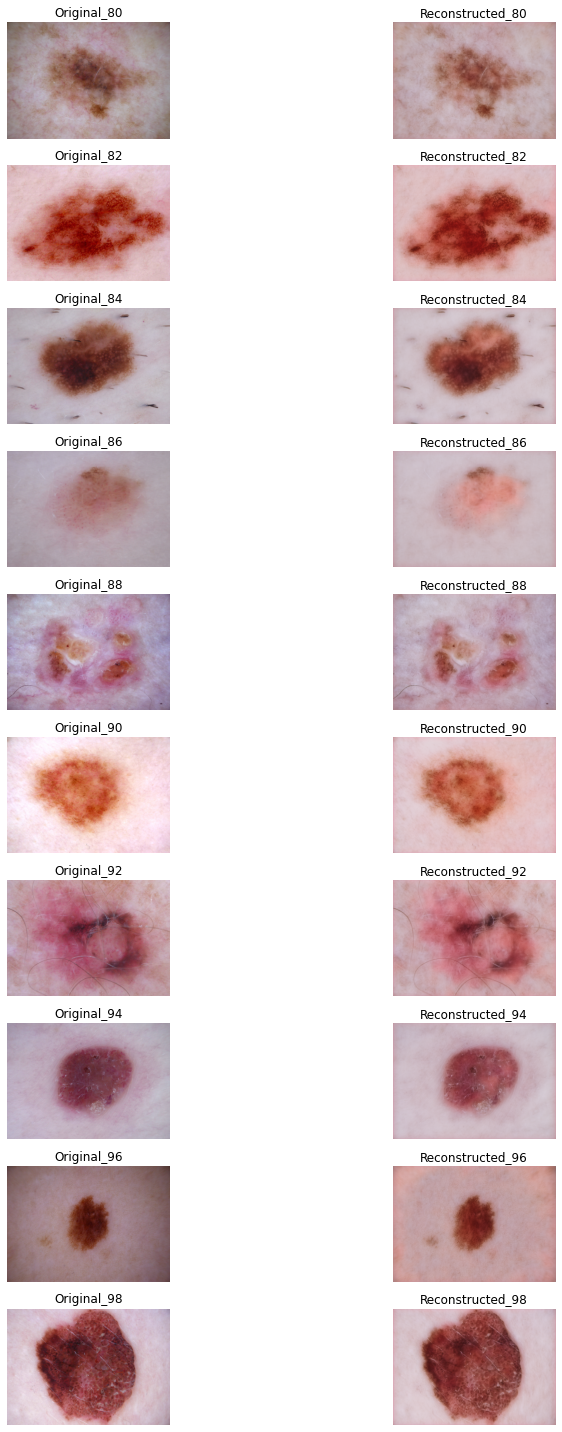

In [18]:
# display multiple original and reconstructed images for the given start index
rows = 10
cols = 2
start_idx = 80

display_multiple_img(final_images, rows, cols, start_idx)

In [19]:
# Select the indices from the above original images to save both the original and reconstructed image
lst_idx = [90]
save_img(final_images, lst_idx)